# Generative AI – Assignment 03
## Question 1 – English → Urdu Neural Machine Translation

This Colab-ready notebook implements:
- Data loading & preprocessing for the **UMC005 English–Urdu parallel corpus**
- A **Seq2Seq LSTM baseline** with attention
- A **Transformer encoder–decoder**
- Training & evaluation (loss curves, BLEU, ROUGE, perplexity)
- Simple **attention visualization** for the Transformer
- A minimal **chat-style translation UI** using Gradio
- (Bonus) Skeleton to fine-tune a pretrained MT model

> **Note:** This notebook is a template. You may adjust hyperparameters, file paths,
> and training epochs according to your GPU/time budget.

In [1]:

# =====================================
# Cell 1: Basic setup & required installs
# =====================================

!pip install -q nltk rouge-score gradio transformers

import os
import re
import math
import random
import time
from collections import Counter
from typing import List, Tuple, Dict

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import nltk
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer

nltk.download('punkt')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


  Preparing metadata (setup.py) ... done


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using device: cuda


## 1. Mount Google Drive and extract UMC005 corpus

Upload `umc005-corpus.zip` into your **Google Drive** folder:

`MyDrive/GenAI_data/umc005-corpus.zip`

Then run the following cells.

In [2]:

# =====================================
# Cell 2: Mount Drive and extract dataset
# =====================================

from google.colab import drive
drive.mount('/content/drive')

DATA_ZIP_PATH = "/content/drive/MyDrive/GenAI_data/umc005-corpus.zip"
EXTRACT_DIR = "/content/umc005_corpus"

import zipfile

if not os.path.exists(EXTRACT_DIR):
    print("Extracting corpus...")
    with zipfile.ZipFile(DATA_ZIP_PATH, 'r') as zf:
        zf.extractall(EXTRACT_DIR)
else:
    print("Corpus directory already exists.")

print("Extracted files:", os.listdir(EXTRACT_DIR))


Mounted at /content/drive
Extracting corpus...
Extracted files: ['quran', 'bible']


In [4]:
import os

print("Files in extracted directory:")
for root, dirs, files in os.walk(EXTRACT_DIR, topdown=True):
    for name in files:
        print(os.path.join(root, name))


Files in extracted directory:
/content/umc005_corpus/quran/Quran-UR
/content/umc005_corpus/quran/train.ur
/content/umc005_corpus/quran/test.en
/content/umc005_corpus/quran/dev.en
/content/umc005_corpus/quran/Quran-UR-normalized
/content/umc005_corpus/quran/train.en
/content/umc005_corpus/quran/test.ur
/content/umc005_corpus/quran/Quran-EN
/content/umc005_corpus/quran/dev.ur
/content/umc005_corpus/bible/Bible-UR-normalized
/content/umc005_corpus/bible/Bible-EN
/content/umc005_corpus/bible/Bible-UR
/content/umc005_corpus/bible/train.ur
/content/umc005_corpus/bible/test.en
/content/umc005_corpus/bible/dev.en
/content/umc005_corpus/bible/train.en
/content/umc005_corpus/bible/test.ur
/content/umc005_corpus/bible/dev.ur


### 1.1 Configure English / Urdu file paths

Inspect the printed file list above and set the correct file names here.
For example, if you have files like `umc005.en` and `umc005.ur`, use those.

In [5]:
# =====================================
# Cell 3: Configure parallel corpus file paths
# =====================================

# Using Quran dataset
EN_FILE = os.path.join(EXTRACT_DIR, "quran/train.en")
UR_FILE = os.path.join(EXTRACT_DIR, "quran/train.ur")

print("English file:", EN_FILE)
print("Urdu file   :", UR_FILE)

assert os.path.exists(EN_FILE), "English file path is wrong. Please fix EN_FILE."
assert os.path.exists(UR_FILE), "Urdu file path is wrong. Please fix UR_FILE."


English file: /content/umc005_corpus/quran/train.en
Urdu file   : /content/umc005_corpus/quran/train.ur


## 2. Preprocessing, tokenization, and vocabulary

We will:
- Load parallel sentences
- Clean and tokenize them
- Build vocabularies for English (source) and Urdu (target)
- Convert to integer sequences with special tokens

In [6]:

# =====================================
# Cell 4: Load parallel data and basic cleaning
# =====================================

MAX_SAMPLES = None  # set to e.g. 50000 for quicker experiments
MIN_LEN = 1
MAX_LEN = 60

def basic_clean(text: str) -> str:
    text = text.strip()
    # Lowercase for English side; Urdu is mostly unaffected
    text = text.replace("\u200c", " ").replace("\u200d", " ")
    text = re.sub(r"\s+", " ", text)
    return text

def load_parallel(en_path: str, ur_path: str, max_samples=None):
    src_sentences = []
    tgt_sentences = []
    with open(en_path, encoding="utf-8") as f_en, open(ur_path, encoding="utf-8") as f_ur:
        for i, (en_line, ur_line) in enumerate(zip(f_en, f_ur)):
            en_line = basic_clean(en_line)
            ur_line = basic_clean(ur_line)

            if not en_line or not ur_line:
                continue

            src_sentences.append(en_line)
            tgt_sentences.append(ur_line)

            if max_samples is not None and len(src_sentences) >= max_samples:
                break

    print(f"Loaded {len(src_sentences)} sentence pairs.")
    return src_sentences, tgt_sentences

src_texts, tgt_texts = load_parallel(EN_FILE, UR_FILE, MAX_SAMPLES)
src_texts[:3], tgt_texts[:3]


Loaded 6000 sentence pairs.


(['\ufeffAll praise be to Allah alone , the Sustainer of all the worlds .',
  'Most Compassionate , Ever - Merciful .',
  'Master of the Day of Judgment .'],
 ['\ufeffسب تعریفیں اللہ ہی کے لئے ہیں جو تمام جہانوں کی پرورش فرمانے والا ہے ۔',
  'نہایت مہربان بہت رحم فرمانے والا ہے ۔',
  'روز جزا کا مالک ہے ۔'])

In [8]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [9]:

# =====================================
# Cell 5: Tokenization and vocabulary
# =====================================

# Special tokens
PAD_TOKEN = "<pad>"
SOS_TOKEN = "<sos>"
EOS_TOKEN = "<eos>"
UNK_TOKEN = "<unk>"

def tokenize_en(text: str) -> List[str]:
    return nltk.word_tokenize(text)

def tokenize_ur(text: str) -> List[str]:
    # Simple whitespace tokenization for Urdu
    return text.split()

class Vocab:
    def __init__(self, tokens_list: List[List[str]], max_size: int = 30000, min_freq: int = 2):
        counter = Counter()
        for toks in tokens_list:
            counter.update(toks)

        # Reserve special tokens
        self.itos = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN]
        self.stoi = {tok: i for i, tok in enumerate(self.itos)}

        for tok, freq in counter.most_common():
            if freq < min_freq:
                continue
            if tok in self.stoi:
                continue
            self.stoi[tok] = len(self.itos)
            self.itos.append(tok)
            if len(self.itos) >= max_size:
                break

    @property
    def pad_idx(self):
        return self.stoi[PAD_TOKEN]

    @property
    def sos_idx(self):
        return self.stoi[SOS_TOKEN]

    @property
    def eos_idx(self):
        return self.stoi[EOS_TOKEN]

    @property
    def unk_idx(self):
        return self.stoi[UNK_TOKEN]

    def encode(self, tokens: List[str], add_sos_eos: bool = True) -> List[int]:
        ids = []
        if add_sos_eos:
            ids.append(self.sos_idx)
        for t in tokens:
            ids.append(self.stoi.get(t, self.unk_idx))
        if add_sos_eos:
            ids.append(self.eos_idx)
        return ids

    def decode(self, ids: List[int], skip_special: bool = True) -> List[str]:
        tokens = []
        for i in ids:
            if i < 0 or i >= len(self.itos):
                continue
            tok = self.itos[i]
            if skip_special and tok in {PAD_TOKEN, SOS_TOKEN, EOS_TOKEN}:
                continue
            tokens.append(tok)
        return tokens

# Tokenize all sentences
src_tokens_list = [tokenize_en(s) for s in src_texts]
tgt_tokens_list = [tokenize_ur(s) for s in tgt_texts]

# Filter by length
filtered_src = []
filtered_tgt = []
for s_tok, t_tok in zip(src_tokens_list, tgt_tokens_list):
    if MIN_LEN <= len(s_tok) <= MAX_LEN and MIN_LEN <= len(t_tok) <= MAX_LEN:
        filtered_src.append(s_tok)
        filtered_tgt.append(t_tok)

print(f"After length filtering: {len(filtered_src)} pairs.")

src_vocab = Vocab(filtered_src, max_size=30000, min_freq=2)
tgt_vocab = Vocab(filtered_tgt, max_size=30000, min_freq=2)

print("Source vocab size:", len(src_vocab.itos))
print("Target vocab size:", len(tgt_vocab.itos))


After length filtering: 4793 pairs.
Source vocab size: 3895
Target vocab size: 3398


In [10]:

# =====================================
# Cell 6: Encode sentences and create splits
# =====================================

src_ids_list = [src_vocab.encode(toks, add_sos_eos=False) for toks in filtered_src]
tgt_ids_list = [tgt_vocab.encode(toks, add_sos_eos=True) for toks in filtered_tgt]

# Train / val / test split
data = list(zip(src_ids_list, tgt_ids_list))
random.shuffle(data)

n_total = len(data)
n_train = int(0.8 * n_total)
n_val = int(0.1 * n_total)

train_data = data[:n_train]
val_data = data[n_train:n_train + n_val]
test_data = data[n_train + n_val:]

print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")


Train: 3834, Val: 479, Test: 480


In [11]:

# =====================================
# Cell 7: PyTorch Dataset and DataLoader with padding
# =====================================

class TranslationDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        src_ids, tgt_ids = self.pairs[idx]
        # For decoder input, we shift right (remove last token)
        tgt_input = tgt_ids[:-1]
        tgt_output = tgt_ids[1:]
        return torch.tensor(src_ids, dtype=torch.long),                            torch.tensor(tgt_input, dtype=torch.long),                            torch.tensor(tgt_output, dtype=torch.long)

def collate_fn(batch):
    src_seqs, tgt_in_seqs, tgt_out_seqs = zip(*batch)

    def pad_seqs(seqs, pad_idx):
        max_len = max(len(s) for s in seqs)
        padded = torch.full((len(seqs), max_len), pad_idx, dtype=torch.long)
        for i, s in enumerate(seqs):
            padded[i, :len(s)] = s
        return padded

    src_padded = pad_seqs(src_seqs, src_vocab.pad_idx)
    tgt_in_padded = pad_seqs(tgt_in_seqs, tgt_vocab.pad_idx)
    tgt_out_padded = pad_seqs(tgt_out_seqs, tgt_vocab.pad_idx)

    return src_padded.to(device), tgt_in_padded.to(device), tgt_out_padded.to(device)

BATCH_SIZE = 64

train_loader = DataLoader(TranslationDataset(train_data),
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          collate_fn=collate_fn)

val_loader = DataLoader(TranslationDataset(val_data),
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        collate_fn=collate_fn)

test_loader = DataLoader(TranslationDataset(test_data),
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         collate_fn=collate_fn)

batch_src, batch_tin, batch_tout = next(iter(train_loader))
print("Example batch shapes:", batch_src.shape, batch_tin.shape, batch_tout.shape)


Example batch shapes: torch.Size([64, 60]) torch.Size([64, 61]) torch.Size([64, 61])


## 3. Baseline: Seq2Seq LSTM with Attention

We implement an encoder–decoder with Bahdanau-style additive attention.

In [12]:

# =====================================
# Cell 8: Seq2Seq LSTM with Attention
# =====================================

class EncoderLSTM(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, num_layers=1, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=src_vocab.pad_idx)
        self.lstm = nn.LSTM(emb_dim, hid_dim, num_layers=num_layers,
                            batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_lengths=None):
        embedded = self.dropout(self.embedding(src))
        outputs, (h, c) = self.lstm(embedded)
        # Concatenate bidirectional hidden and pass through linear
        h_cat = torch.cat((h[-2], h[-1]), dim=1)
        h0 = torch.tanh(self.fc(h_cat)).unsqueeze(0)
        c0 = torch.zeros_like(h0)
        return outputs, (h0, c0)


class BahdanauAttention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.attn = nn.Linear(enc_hid_dim * 2 + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs, mask=None):
        batch_size = encoder_outputs.size(0)
        src_len = encoder_outputs.size(1)

        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        scores = self.v(energy).squeeze(2)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attn_weights = F.softmax(scores, dim=1)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        return context, attn_weights


class DecoderLSTM(nn.Module):
    def __init__(self, vocab_size, emb_dim, enc_hid_dim, dec_hid_dim, attention, num_layers=1, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=tgt_vocab.pad_idx)
        self.attention = attention
        self.lstm = nn.LSTM(emb_dim + enc_hid_dim * 2, dec_hid_dim,
                            num_layers=num_layers, batch_first=True)
        self.fc_out = nn.Linear(dec_hid_dim + enc_hid_dim * 2, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_step, hidden, cell, encoder_outputs, src_mask=None):
        embedded = self.dropout(self.embedding(input_step.unsqueeze(1)))
        context, attn_weights = self.attention(hidden.squeeze(0), encoder_outputs, src_mask)
        context = context.unsqueeze(1)
        lstm_input = torch.cat((embedded, context), dim=2)
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        output = output.squeeze(1)
        logits = self.fc_out(torch.cat((output, context.squeeze(1)), dim=1))
        return logits, hidden, cell, attn_weights


class Seq2SeqLSTM(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def create_src_mask(self, src):
        return (src != src_vocab.pad_idx).to(src.device)

    def forward(self, src, tgt_in):
        encoder_outputs, (h, c) = self.encoder(src)
        src_mask = self.create_src_mask(src)
        batch_size, tgt_len = tgt_in.size()
        outputs = torch.zeros(batch_size, tgt_len, len(tgt_vocab.itos), device=src.device)

        hidden, cell = h, c
        input_step = tgt_in[:, 0]

        for t in range(1, tgt_len):
            logits, hidden, cell, _ = self.decoder(input_step, hidden, cell, encoder_outputs, src_mask)
            outputs[:, t, :] = logits
            input_step = tgt_in[:, t]

        return outputs


In [16]:

# =====================================
# Cell 9: Training utilities for Seq2Seq LSTM
# =====================================

def sequence_cross_entropy(logits, targets, pad_idx):
    # Use reshape instead of view to avoid contiguity issues
    logits_flat = logits.reshape(-1, logits.size(-1))
    targets_flat = targets.reshape(-1)
    loss = F.cross_entropy(logits_flat, targets_flat, ignore_index=pad_idx)
    return loss


def train_epoch_seq2seq(model, dataloader, optimizer):
    model.train()
    total_loss = 0.0
    for src, tgt_in, tgt_out in dataloader:
        optimizer.zero_grad()
        logits = model(src, tgt_in)
        loss = sequence_cross_entropy(logits[:, 1:, :], tgt_out[:, 1:], tgt_vocab.pad_idx)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def eval_epoch_seq2seq(model, dataloader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for src, tgt_in, tgt_out in dataloader:
            logits = model(src, tgt_in)
            loss = sequence_cross_entropy(logits[:, 1:, :], tgt_out[:, 1:], tgt_vocab.pad_idx)
            total_loss += loss.item()
    return total_loss / len(dataloader)

def greedy_translate_seq2seq(model, src_sentence: str, max_len: int = 50):
    model.eval()
    src_tokens = tokenize_en(basic_clean(src_sentence))
    src_ids = torch.tensor([src_vocab.encode(src_tokens, add_sos_eos=False)], device=device)
    with torch.no_grad():
        enc_outputs, (h, c) = model.encoder(src_ids)
        src_mask = model.create_src_mask(src_ids)
        input_step = torch.full((1,), tgt_vocab.sos_idx, dtype=torch.long, device=device)
        hidden, cell = h, c
        generated = []
        for _ in range(max_len):
            logits, hidden, cell, _ = model.decoder(input_step, hidden, cell, enc_outputs, src_mask)
            next_token = logits.argmax(dim=-1)
            token_id = next_token.item()
            if token_id == tgt_vocab.eos_idx:
                break
            generated.append(token_id)
            input_step = next_token
    return " ".join(tgt_vocab.decode(generated))


In [17]:

# =====================================
# Cell 10: Train Seq2Seq LSTM (baseline)
# =====================================

ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 256
NUM_LAYERS = 1
DROPOUT = 0.2
N_EPOCHS_LSTM = 5  # increase for better results

attention = BahdanauAttention(enc_hid_dim=HID_DIM, dec_hid_dim=HID_DIM)
encoder = EncoderLSTM(len(src_vocab.itos), ENC_EMB_DIM, HID_DIM, NUM_LAYERS, DROPOUT)
decoder = DecoderLSTM(len(tgt_vocab.itos), DEC_EMB_DIM, HID_DIM, HID_DIM, attention, NUM_LAYERS, DROPOUT)

seq2seq_lstm = Seq2SeqLSTM(encoder, decoder).to(device)
optimizer_lstm = torch.optim.Adam(seq2seq_lstm.parameters(), lr=1e-3)

train_losses_lstm = []
val_losses_lstm = []

for epoch in range(1, N_EPOCHS_LSTM + 1):
    start = time.time()
    tr_loss = train_epoch_seq2seq(seq2seq_lstm, train_loader, optimizer_lstm)
    val_loss = eval_epoch_seq2seq(seq2seq_lstm, val_loader)
    train_losses_lstm.append(tr_loss)
    val_losses_lstm.append(val_loss)
    print(f"[LSTM] Epoch {epoch}/{N_EPOCHS_LSTM} - "
          f"Train loss: {tr_loss:.4f}, Val loss: {val_loss:.4f}, "
          f"Time: {time.time()-start:.1f}s")


[LSTM] Epoch 1/5 - Train loss: 6.1103, Val loss: 5.6743, Time: 12.4s
[LSTM] Epoch 2/5 - Train loss: 5.4303, Val loss: 5.2919, Time: 11.8s
[LSTM] Epoch 3/5 - Train loss: 5.0276, Val loss: 5.0248, Time: 12.0s
[LSTM] Epoch 4/5 - Train loss: 4.6791, Val loss: 4.7935, Time: 12.2s
[LSTM] Epoch 5/5 - Train loss: 4.3350, Val loss: 4.6030, Time: 12.4s


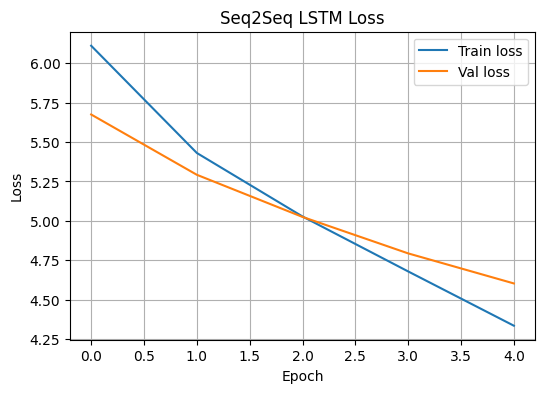

In [18]:

# =====================================
# Cell 11: Plot LSTM loss curves
# =====================================

plt.figure(figsize=(6,4))
plt.plot(train_losses_lstm, label="Train loss")
plt.plot(val_losses_lstm, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Seq2Seq LSTM Loss")
plt.legend()
plt.grid(True)
plt.show()


## 4. Transformer Encoder–Decoder for MT

We now implement a Transformer-based sequence-to-sequence model.
This version also exposes cross-attention weights for visualization.

In [24]:

# =====================================
# Cell 12: Transformer building blocks
# =====================================

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.attn_weights = None  # for visualization

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        Q = self.W_q(query)
        K = self.W_k(key)
        V = self.W_v(value)

        def split_heads(x):
            return x.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        Q = split_heads(Q)
        K = split_heads(K)
        V = split_heads(V)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            #mask = mask.unsqueeze(1)
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        self.attn_weights = attn  # (batch, heads, q_len, k_len)

        context = torch.matmul(attn, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.W_o(context)
        return output

class FeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))

class EncoderLayer(nn.Module):
    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask=None):
        attn_out = self.self_attn(src, src, src, src_mask)
        src = self.norm1(src + self.dropout(attn_out))
        ff_out = self.ff(src)
        src = self.norm2(src + self.dropout(ff_out))
        return src

class DecoderLayer(nn.Module):
    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.cross_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        _tgt = self.self_attn(tgt, tgt, tgt, tgt_mask)
        tgt = self.norm1(tgt + self.dropout(_tgt))
        _tgt2 = self.cross_attn(tgt, memory, memory, memory_mask)
        tgt = self.norm2(tgt + self.dropout(_tgt2))
        ff_out = self.ff(tgt)
        tgt = self.norm3(tgt + self.dropout(ff_out))
        return tgt


In [25]:
# =====================================
# Cell 13: Full Transformer model
# =====================================

class TransformerMT(nn.Module):
    def __init__(self,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 d_model: int = 256,
                 num_heads: int = 4,
                 num_layers: int = 3,
                 d_ff: int = 512,
                 dropout: float = 0.1,
                 max_len: int = 200):
        super().__init__()
        self.src_embed = nn.Embedding(src_vocab_size, d_model, padding_idx=src_vocab.pad_idx)
        self.tgt_embed = nn.Embedding(tgt_vocab_size, d_model, padding_idx=tgt_vocab.pad_idx)
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        self.pos_decoder = PositionalEncoding(d_model, max_len)

        self.encoder_layers = nn.ModuleList(
            [EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)]
        )
        self.decoder_layers = nn.ModuleList(
            [DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)]
        )
        self.generator = nn.Linear(d_model, tgt_vocab_size)

        self.d_model = d_model
        self.num_layers = num_layers

    def make_src_mask(self, src):
        """
        src: (batch, src_len)
        Returns mask of shape (batch, 1, 1, src_len) for encoder self-attention
        and decoder cross-attention.
        """
        pad_mask = (src != src_vocab.pad_idx)  # (batch, src_len)
        return pad_mask.unsqueeze(1).unsqueeze(2)  # (batch, 1, 1, src_len)

    def make_tgt_mask(self, tgt):
        """
        tgt: (batch, tgt_len)
        Returns mask of shape (batch, 1, tgt_len, tgt_len) combining:
        - padding mask
        - subsequent (causal) mask
        """
        batch_size, tgt_len = tgt.size()
        pad_mask = (tgt != tgt_vocab.pad_idx).unsqueeze(1).unsqueeze(2)  # (batch, 1, 1, tgt_len)

        subsequent_mask = torch.triu(
            torch.ones((1, 1, tgt_len, tgt_len), device=tgt.device),
            diagonal=1
        ).bool()  # (1, 1, tgt_len, tgt_len)

        # True where tokens are allowed (not pad and not future)
        combined_mask = pad_mask & ~subsequent_mask  # (batch, 1, tgt_len, tgt_len)
        return combined_mask

    def encode(self, src):
        src_emb = self.pos_encoder(self.src_embed(src))
        src_mask = self.make_src_mask(src)
        memory = src_emb
        for layer in self.encoder_layers:
            memory = layer(memory, src_mask)
        return memory, src_mask

    def decode(self, tgt, memory, src_mask):
        tgt_emb = self.pos_decoder(self.tgt_embed(tgt))
        tgt_mask = self.make_tgt_mask(tgt)
        out = tgt_emb
        for layer in self.decoder_layers:
            out = layer(out, memory, tgt_mask, src_mask)
        logits = self.generator(out)
        return logits

    def forward(self, src, tgt_in):
        memory, src_mask = self.encode(src)
        logits = self.decode(tgt_in, memory, src_mask)
        return logits

    def greedy_decode_with_attention(self, src, max_len: int = 50):
        memory, src_mask = self.encode(src)
        batch_size = src.size(0)
        generated = torch.full(
            (batch_size, 1),
            tgt_vocab.sos_idx,
            dtype=torch.long,
            device=src.device
        )
        attn_maps = []

        for _ in range(max_len):
            tgt_emb = self.pos_decoder(self.tgt_embed(generated))
            tgt_mask = self.make_tgt_mask(generated)
            out = tgt_emb
            cross_attn_weights = None

            for layer in self.decoder_layers:
                out = layer(out, memory, tgt_mask, src_mask)
                cross_attn_weights = layer.cross_attn.attn_weights

            logits = self.generator(out)
            next_token = logits[:, -1, :].argmax(dim=-1, keepdim=True)
            generated = torch.cat([generated, next_token], dim=1)

            if cross_attn_weights is not None:
                # shape: (batch, heads, 1, src_len) for the last generated token
                attn_maps.append(cross_attn_weights[:, :, -1, :].detach().cpu())

            if (next_token == tgt_vocab.eos_idx).all():
                break

        return generated, attn_maps


In [26]:

# =====================================
# Cell 14: Training utilities for Transformer
# =====================================

def train_epoch_transformer(model, dataloader, optimizer):
    model.train()
    total_loss = 0.0
    for src, tgt_in, tgt_out in dataloader:
        optimizer.zero_grad()
        logits = model(src, tgt_in)
        loss = sequence_cross_entropy(logits[:, 1:, :], tgt_out[:, 1:], tgt_vocab.pad_idx)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)


In [27]:

def eval_epoch_transformer(model, dataloader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for src, tgt_in, tgt_out in dataloader:
            logits = model(src, tgt_in)
            loss = sequence_cross_entropy(logits[:, 1:, :], tgt_out[:, 1:], tgt_vocab.pad_idx)
            total_loss += loss.item()
    return total_loss / len(dataloader)

def greedy_translate_transformer(model, src_sentence: str, max_len: int = 50):
    model.eval()
    src_tokens = tokenize_en(basic_clean(src_sentence))
    src_ids = torch.tensor([src_vocab.encode(src_tokens, add_sos_eos=False)], device=device)
    with torch.no_grad():
        out_ids, _ = model.greedy_decode_with_attention(src_ids, max_len=max_len)
    out_seq = out_ids[0].tolist()[1:]
    if tgt_vocab.eos_idx in out_seq:
        out_seq = out_seq[:out_seq.index(tgt_vocab.eos_idx)]
    return " ".join(tgt_vocab.decode(out_seq))


In [28]:

# =====================================
# Cell 15: Train Transformer MT model
# =====================================

D_MODEL = 256
NUM_HEADS = 4
NUM_LAYERS = 3
D_FF = 512
DROPOUT = 0.1
N_EPOCHS_TRANS = 5  # increase for better results

transformer_mt = TransformerMT(len(src_vocab.itos),
                               len(tgt_vocab.itos),
                               d_model=D_MODEL,
                               num_heads=NUM_HEADS,
                               num_layers=NUM_LAYERS,
                               d_ff=D_FF,
                               dropout=DROPOUT).to(device)

optimizer_trans = torch.optim.Adam(transformer_mt.parameters(), lr=1e-4)

train_losses_trans = []
val_losses_trans = []

for epoch in range(1, N_EPOCHS_TRANS + 1):
    start = time.time()
    tr_loss = train_epoch_transformer(transformer_mt, train_loader, optimizer_trans)
    val_loss = eval_epoch_transformer(transformer_mt, val_loader)
    train_losses_trans.append(tr_loss)
    val_losses_trans.append(val_loss)
    print(f"[Transformer] Epoch {epoch}/{N_EPOCHS_TRANS} - "
          f"Train loss: {tr_loss:.4f}, Val loss: {val_loss:.4f}, "
          f"Time: {time.time()-start:.1f}s")


[Transformer] Epoch 1/5 - Train loss: 6.8544, Val loss: 6.0554, Time: 3.7s
[Transformer] Epoch 2/5 - Train loss: 5.7348, Val loss: 5.4734, Time: 3.6s
[Transformer] Epoch 3/5 - Train loss: 5.2985, Val loss: 5.1388, Time: 3.6s
[Transformer] Epoch 4/5 - Train loss: 4.9946, Val loss: 4.8948, Time: 3.6s
[Transformer] Epoch 5/5 - Train loss: 4.7541, Val loss: 4.7077, Time: 3.6s


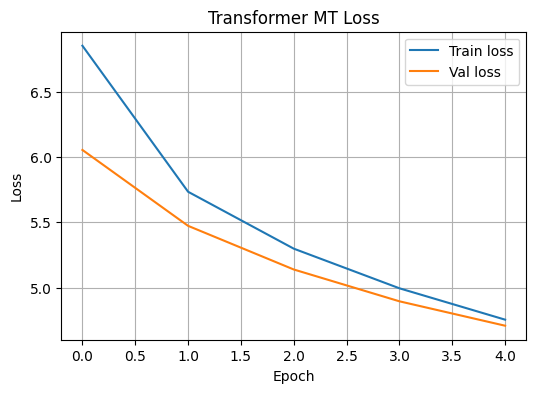

In [29]:

# =====================================
# Cell 16: Plot Transformer loss curves
# =====================================

plt.figure(figsize=(6,4))
plt.plot(train_losses_trans, label="Train loss")
plt.plot(val_losses_trans, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Transformer MT Loss")
plt.legend()
plt.grid(True)
plt.show()


## 5. Evaluation: BLEU, ROUGE, and Perplexity

We compare Transformer vs LSTM on the test set.

In [30]:

# =====================================
# Cell 17: Helper for decoding all predictions
# =====================================

def evaluate_model_text(model, dataloader, max_batches=None):
    model.eval()
    references = []
    hypotheses = []
    with torch.no_grad():
        for i, (src, tgt_in, tgt_out) in enumerate(dataloader):
            if max_batches is not None and i >= max_batches:
                break
            out_ids, _ = model.greedy_decode_with_attention(src, max_len=50)
            for j in range(src.size(0)):
                tgt_seq = tgt_out[j].tolist()
                if tgt_vocab.eos_idx in tgt_seq:
                    tgt_seq = tgt_seq[:tgt_seq.index(tgt_vocab.eos_idx)]
                ref_tokens = tgt_vocab.decode(tgt_seq)
                references.append([ref_tokens])

                gen_seq = out_ids[j].tolist()[1:]
                if tgt_vocab.eos_idx in gen_seq:
                    gen_seq = gen_seq[:gen_seq.index(tgt_vocab.eos_idx)]
                hyp_tokens = tgt_vocab.decode(gen_seq)
                hypotheses.append(hyp_tokens)
    return references, hypotheses

def bleu_rouge_from_text(references, hypotheses):
    bleu = corpus_bleu(references, hypotheses) * 100
    scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=False)
    rouge_scores = []
    for ref, hyp in zip(references, hypotheses):
        ref_str = " ".join(ref[0])
        hyp_str = " ".join(hyp)
        score = scorer.score(ref_str, hyp_str)["rougeL"].fmeasure
        rouge_scores.append(score)
    rouge_l = np.mean(rouge_scores) * 100
    return bleu, rouge_l


In [31]:

# =====================================
# Cell 18: Compute metrics for Transformer and LSTM
# =====================================

# For speed, you can limit max_batches (e.g. 50). Set to None for full test set.
MAX_EVAL_BATCHES = 50

# Transformer
refs_trans, hyps_trans = evaluate_model_text(transformer_mt, test_loader, max_batches=MAX_EVAL_BATCHES)
bleu_trans, rouge_trans = bleu_rouge_from_text(refs_trans, hyps_trans)
print(f"Transformer BLEU: {bleu_trans:.2f}, ROUGE-L: {rouge_trans:.2f}")

# LSTM baseline: use a wrapper that mimics greedy_decode_with_attention
def evaluate_model_text_lstm(model, dataloader, max_batches=None):
    model.eval()
    references = []
    hypotheses = []
    with torch.no_grad():
        for i, (src, tgt_in, tgt_out) in enumerate(dataloader):
            if max_batches is not None and i >= max_batches:
                break
            for j in range(src.size(0)):
                src_sent = src[j:j+1]
                enc_outputs, (h, c) = model.encoder(src_sent)
                src_mask = model.create_src_mask(src_sent)
                input_step = torch.full((1,), tgt_vocab.sos_idx, dtype=torch.long, device=device)
                hidden, cell = h, c
                gen_ids = []
                for _ in range(50):
                    logits, hidden, cell, _ = model.decoder(input_step, hidden, cell, enc_outputs, src_mask)
                    next_token = logits.argmax(dim=-1)
                    tid = next_token.item()
                    if tid == tgt_vocab.eos_idx:
                        break
                    gen_ids.append(tid)
                    input_step = next_token

                tgt_seq = tgt_out[j].tolist()
                if tgt_vocab.eos_idx in tgt_seq:
                    tgt_seq = tgt_seq[:tgt_seq.index(tgt_vocab.eos_idx)]
                ref_tokens = tgt_vocab.decode(tgt_seq)
                references.append([ref_tokens])
                hyp_tokens = tgt_vocab.decode(gen_ids)
                hypotheses.append(hyp_tokens)
    return references, hypotheses

refs_lstm, hyps_lstm = evaluate_model_text_lstm(seq2seq_lstm, test_loader, max_batches=MAX_EVAL_BATCHES)
bleu_lstm, rouge_lstm = bleu_rouge_from_text(refs_lstm, hyps_lstm)
print(f"LSTM BLEU: {bleu_lstm:.2f}, ROUGE-L: {rouge_lstm:.2f}")

# Approximate perplexity from validation loss
def perplexity(loss):
    return math.exp(loss)

print("Transformer Val Perplexity:", perplexity(val_losses_trans[-1]))
print("LSTM Val Perplexity       :", perplexity(val_losses_lstm[-1]))


Transformer BLEU: 2.16, ROUGE-L: 6.76
LSTM BLEU: 0.42, ROUGE-L: 4.29
Transformer Val Perplexity: 110.79845488259392
LSTM Val Perplexity       : 99.78387542077257


## 6. Attention visualization (Transformer)

We visualize which English tokens the Transformer attends to while generating Urdu tokens.

In [32]:

# =====================================
# Cell 19: Attention visualization helper
# =====================================

def visualize_attention(transformer_model, en_sentence: str):
    transformer_model.eval()
    src_tokens = tokenize_en(basic_clean(en_sentence))
    src_ids = torch.tensor([src_vocab.encode(src_tokens, add_sos_eos=False)], device=device)
    with torch.no_grad():
        out_ids, attn_maps = transformer_model.greedy_decode_with_attention(src_ids, max_len=40)

    out_seq = out_ids[0].tolist()[1:]
    if tgt_vocab.eos_idx in out_seq:
        out_seq = out_seq[:out_seq.index(tgt_vocab.eos_idx)]
    tgt_tokens = tgt_vocab.decode(out_seq)

    if not attn_maps:
        print("No attention maps captured.")
        return

    attn_tensor = attn_maps[-1]
    attn_mean = attn_tensor.mean(dim=1).squeeze(0)

    src_tokens_vis = src_tokens
    tgt_tokens_vis = tgt_tokens

    plt.figure(figsize=(max(6, len(src_tokens_vis)*0.6), max(4, len(tgt_tokens_vis)*0.6)))
    plt.imshow(attn_mean[:len(tgt_tokens_vis), :len(src_tokens_vis)].cpu().numpy(), aspect='auto')
    plt.xticks(range(len(src_tokens_vis)), src_tokens_vis, rotation=45, ha='right')
    plt.yticks(range(len(tgt_tokens_vis)), tgt_tokens_vis)
    plt.xlabel("Source (English)")
    plt.ylabel("Target (Urdu)")
    plt.title("Transformer cross-attention (averaged over heads)")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# Example (run after training):
# visualize_attention(transformer_mt, "How are you today?")


## 7. Simple chat-style translation UI (Gradio)

We build a minimal interface where the user types English and the model returns Urdu.

In [35]:

# =====================================
# Cell 20: Gradio-based chat UI
# =====================================

import gradio as gr

def translate_chat(history, user_input):
    history = history or []
    urdu = greedy_translate_transformer(transformer_mt, user_input)
    history.append((user_input, urdu))
    return history, ""

with gr.Blocks() as demo:
    gr.Markdown("# English → Urdu MT (Transformer)")
    chatbot = gr.Chatbot(height=400)
    msg = gr.Textbox(label="Enter English text")
    clear = gr.Button("Clear")

    msg.submit(translate_chat, [chatbot, msg], [chatbot, msg])
    clear.click(lambda: ([], ""), None, [chatbot, msg])

# To launch in Colab:
demo.launch(share=True)


/tmp/ipython-input-1774081602.py:15: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(height=400)
/tmp/ipython-input-1774081602.py:15: DeprecationWarning: The default value of 'allow_tags' in gr.Chatbot will be changed from False to True in Gradio 6.0. You will need to explicitly set allow_tags=False if you want to disable tags in your chatbot.
  chatbot = gr.Chatbot(height=400)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e5892370278593f62d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 8. Bonus: Fine-tuning a pretrained MT model (skeleton)

Here we show a basic skeleton to fine-tune a pretrained HuggingFace model
like `Helsinki-NLP/opus-mt-en-ur` on the same corpus. You can expand this
with full training arguments and logging as needed.

In [ ]:

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = "Helsinki-NLP/opus-mt-en-ur"

tokenizer_pre = AutoTokenizer.from_pretrained(model_name)
model_pre = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

def encode_example_batch(src_texts_batch, tgt_texts_batch, max_length=64):
    model_inputs = tokenizer_pre(src_texts_batch,
                                 padding=True,
                                 truncation=True,
                                 max_length=max_length,
                                 return_tensors="pt")
    with tokenizer_pre.as_target_tokenizer():
        labels = tokenizer_pre(tgt_texts_batch,
                               padding=True,
                               truncation=True,
                               max_length=max_length,
                               return_tensors="pt")["input_ids"]
    model_inputs["labels"] = labels
    return {k: v.to(device) for k, v in model_inputs.items()}

# Example forward pass on a small subset
example_src = src_texts[:4]
example_tgt = tgt_texts[:4]
batch_enc = encode_example_batch(example_src, example_tgt)
with torch.no_grad():
    out = model_pre(**batch_enc)
print("Pretrained model example loss:", float(out.loss))



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

source.spm:   0%|          | 0.00/816k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/848k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/306M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Pretrained model example loss: 2.397023916244507


/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4118: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
